# Thin Plasma Lens 2

In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from numpy.fft import fft, ifft, fftfreq, fftshift
from beam import interactions
from beam.beams import laserbeam
from propagation import laser
from ionization import ionization
from lens import design
from lens import bessel
from lens import ray
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.style.use('presentation')

path = '/mnt/md0/Data/rariniello/TPL/TPL_2/'
lam = 0.796
# All length units are in um

Attempt to make a usable thin plasma lens using a cylindircal lens, a prism, and a mask.

In [2]:
# Design the cylidrical lens and the prism
# Target plasma length of 752um and width of 200um
# Width of 200um corresponds to about f=1m for a 1cm beam
f1 = 0.015e6
# TPL length is slit size w_s/sin(beta)
# Width from the prism is w_s/cos(beta)
w_s = 0.1e3
beta = 0.5*np.pi/180
# The distance from the optic to the plasma is r_s/tan(beta)
r_s = f1*np.tan(beta)
print(r_s)

130.903016861


In [3]:
w0 = 14.55
w_s/np.tan(beta)

11458.865012930961

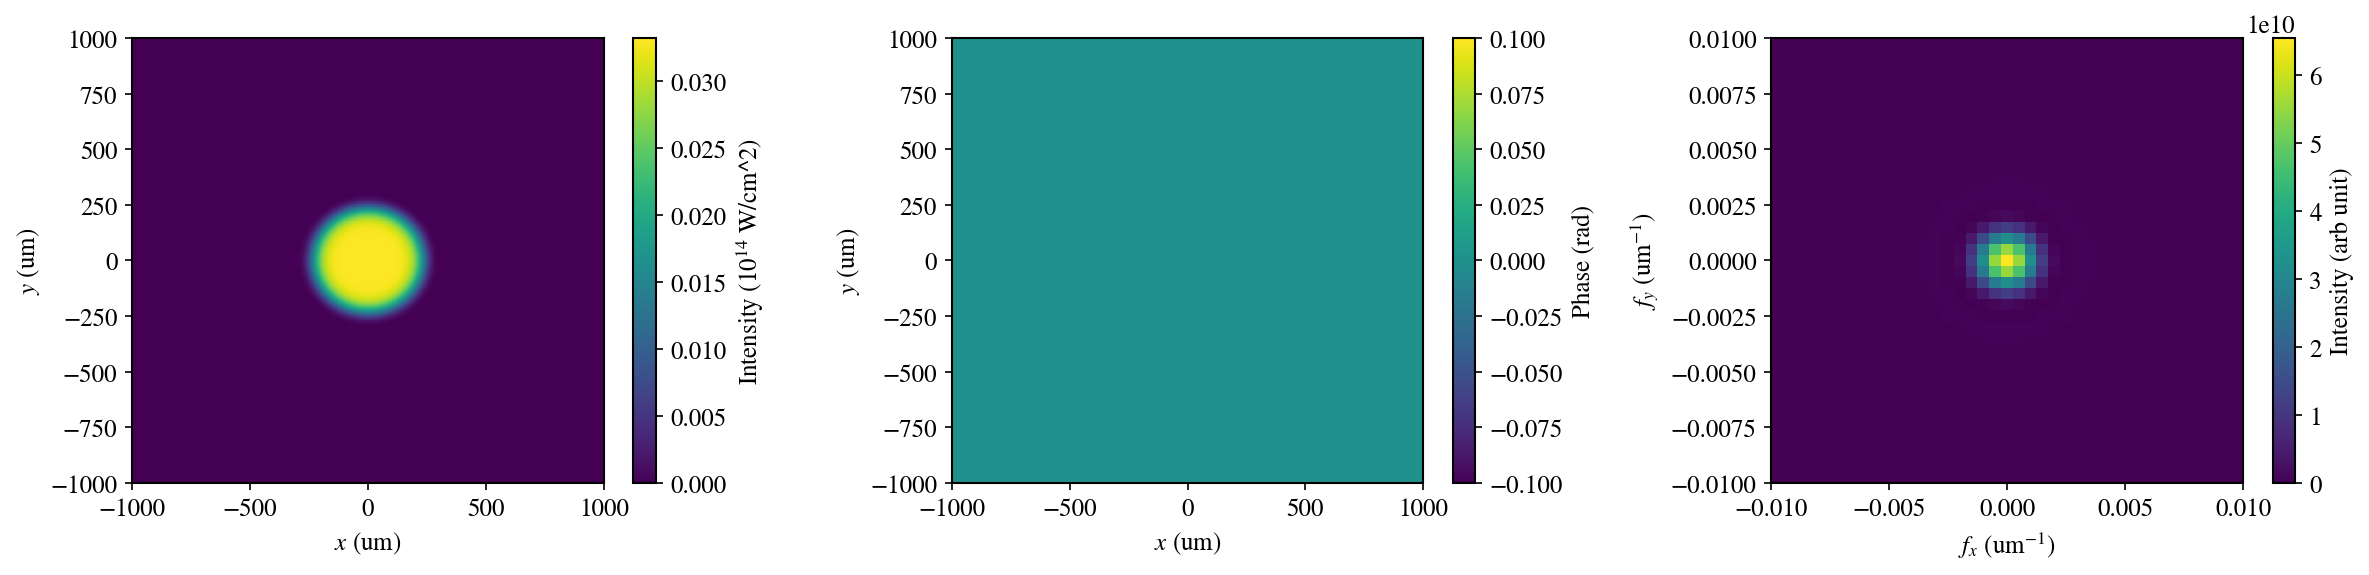

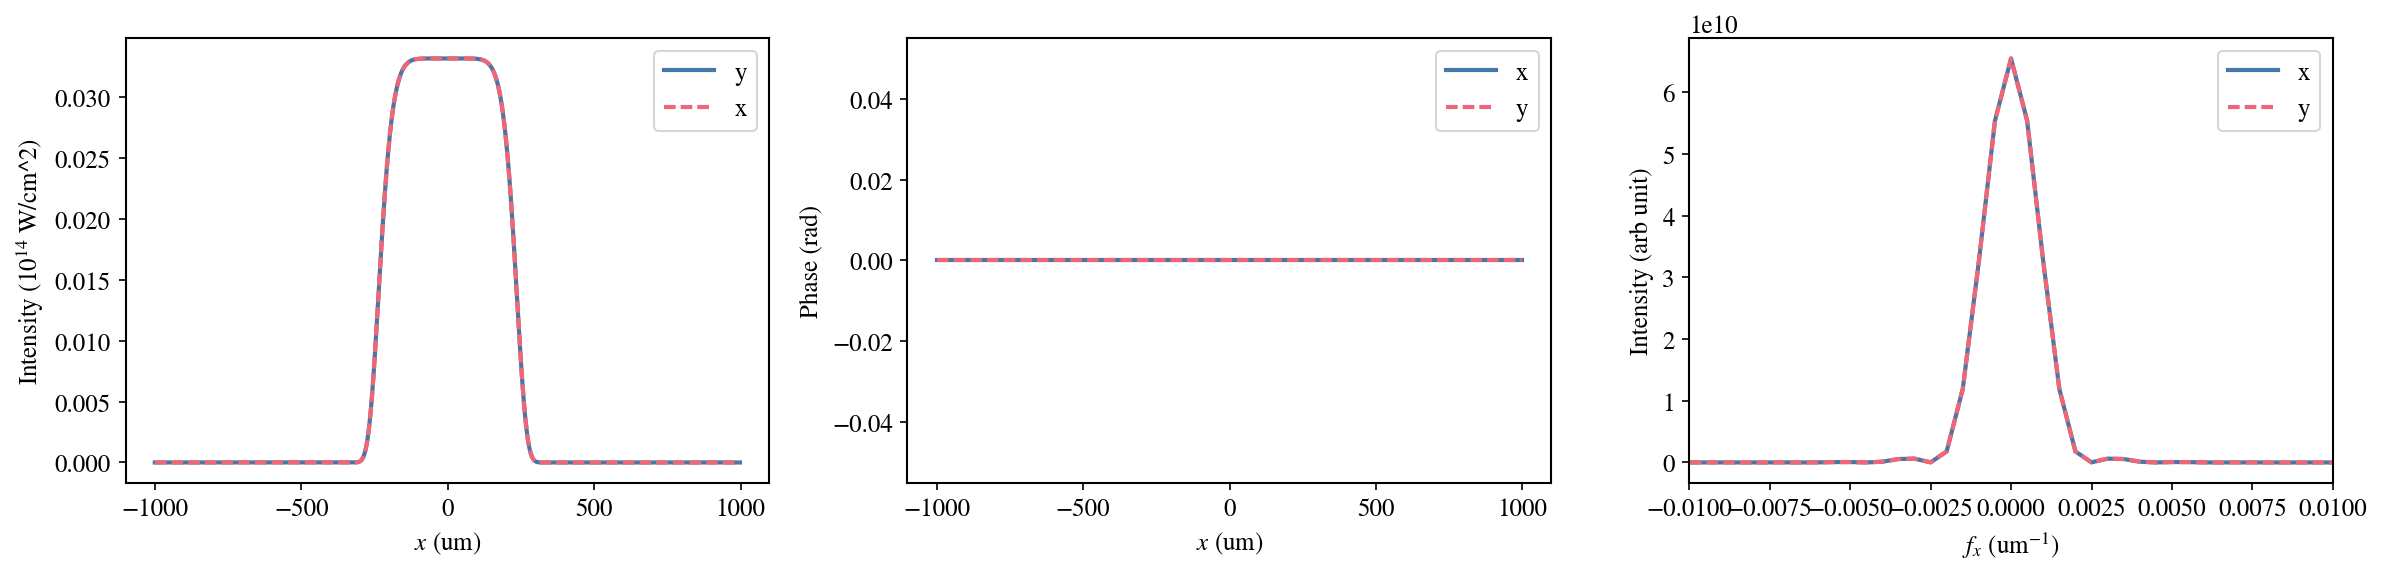

In [4]:
Nx = 2**10
X = 2e3
n = 8
w0 = 2*r_s

beamParams = {'Nx' : Nx,
              'Ny' : Nx,
              'X' : X,
              'Y' : X,
              'lam' : lam,
              'path' : path,
              'name' : 'Input_beam',
              'threads' : 20,
              'cyl' : True,
              'load' : False,
              'E0' : 5.0,
              'waist' : w0,
              'order' : n}

# Super Gaussian for simulation
beam_in = laserbeam.SuperGaussianLaser(beamParams)
beam_in.plot_current_field(flim=[-0.01, 0.01])

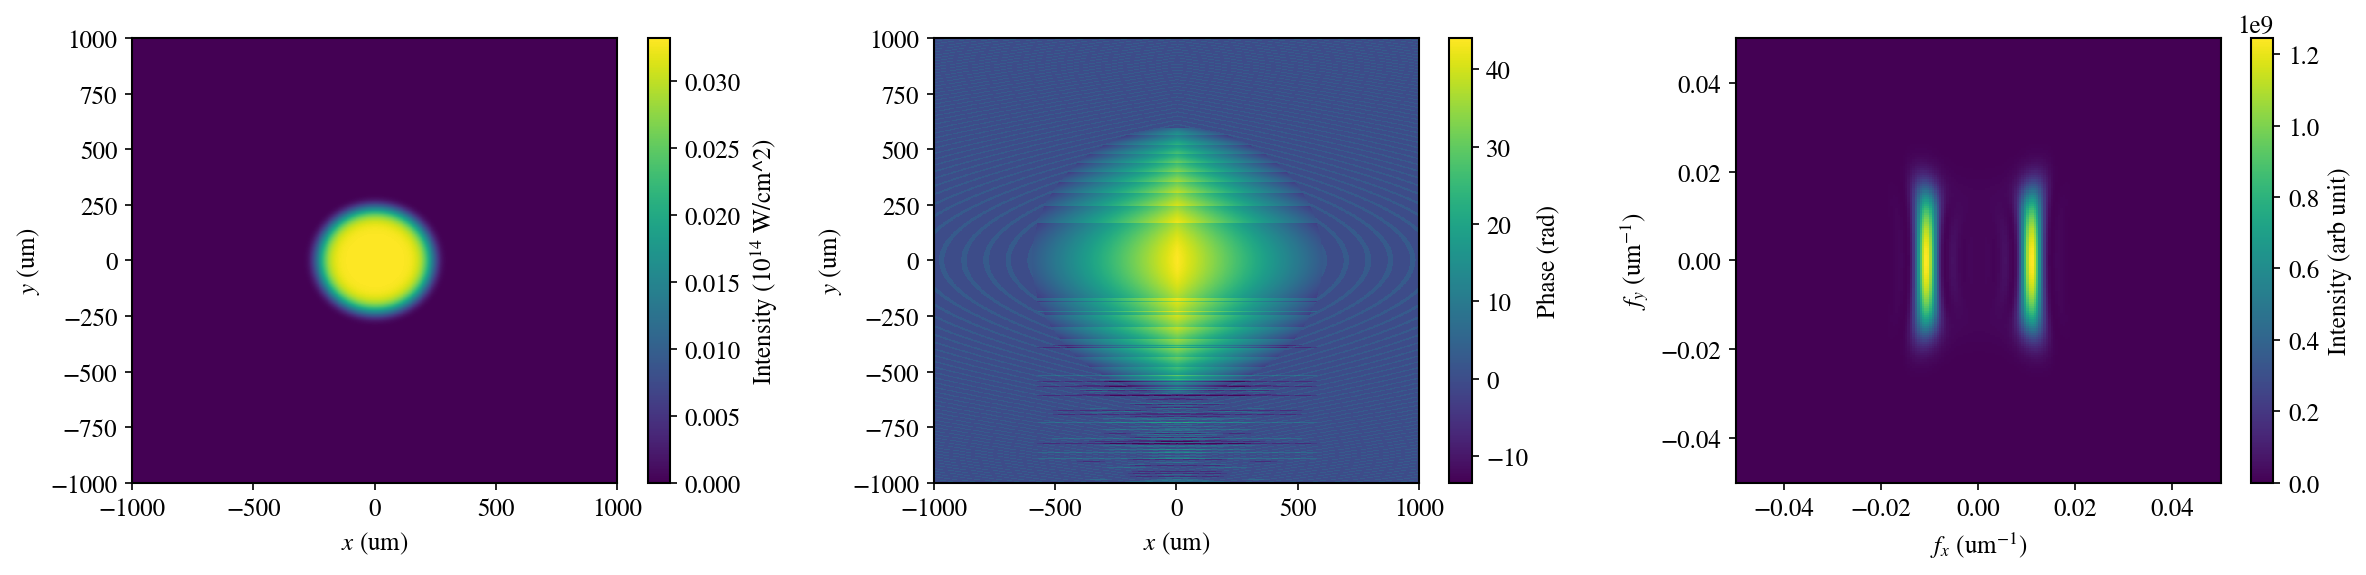

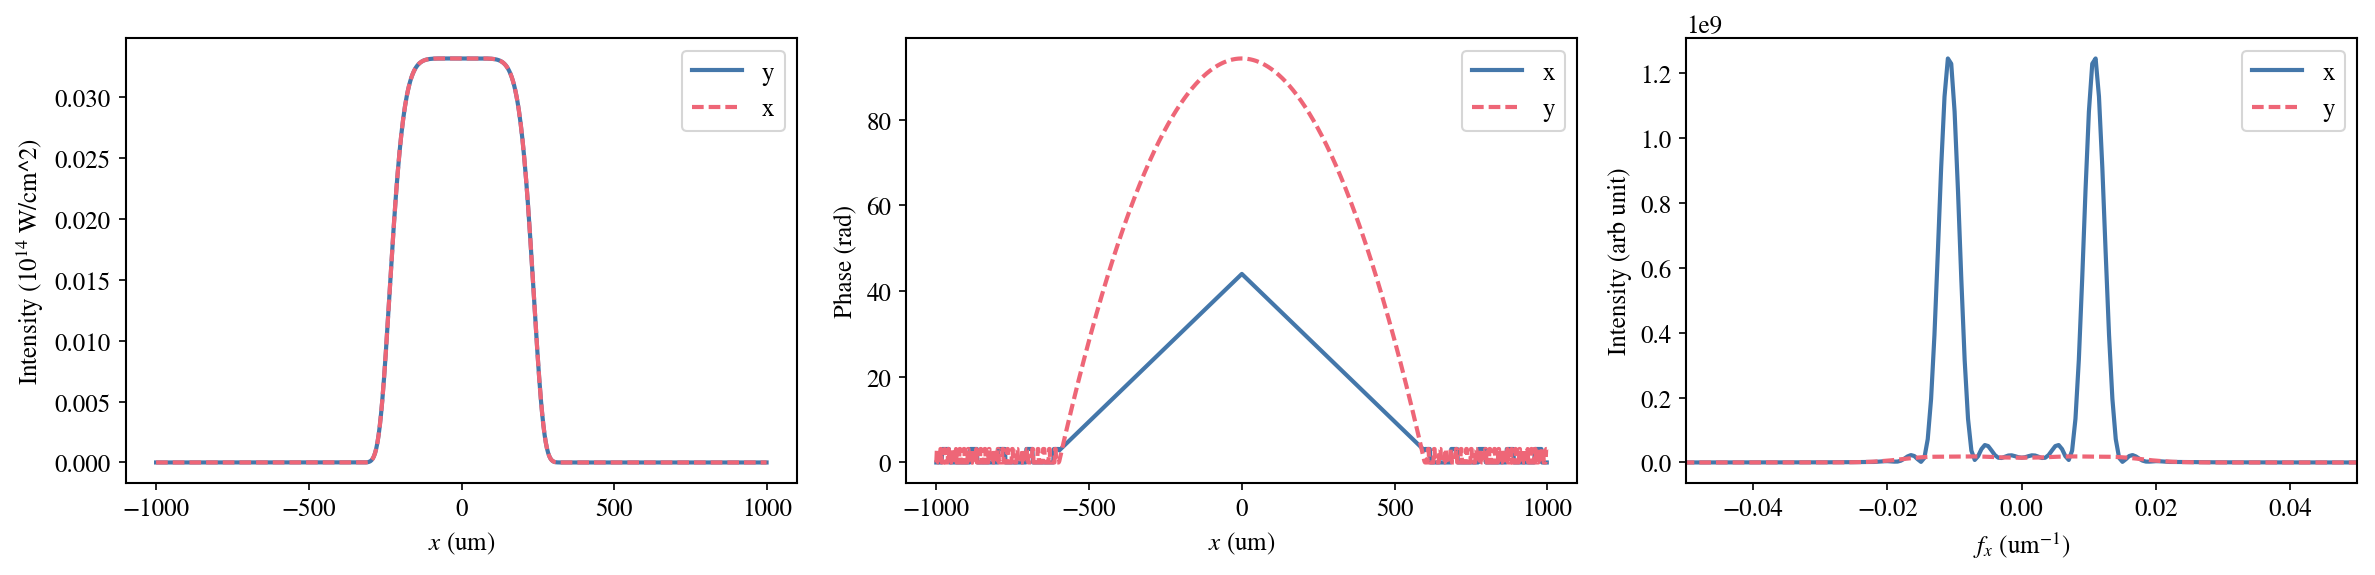

In [5]:
# Apply a cylindrical lens phase, a prism phase, and a double slit aperture
phi_x = -beam_in.k * beta * abs(beam_in.x[:, None])
phi_y = -beam_in.k * (beam_in.y[None, :]**2) / (2*f1)
phi = phi_x + phi_y
beam_in.e *= np.exp(1j*phi)
beam_in.plot_current_field(flim=[-0.05, 0.05])

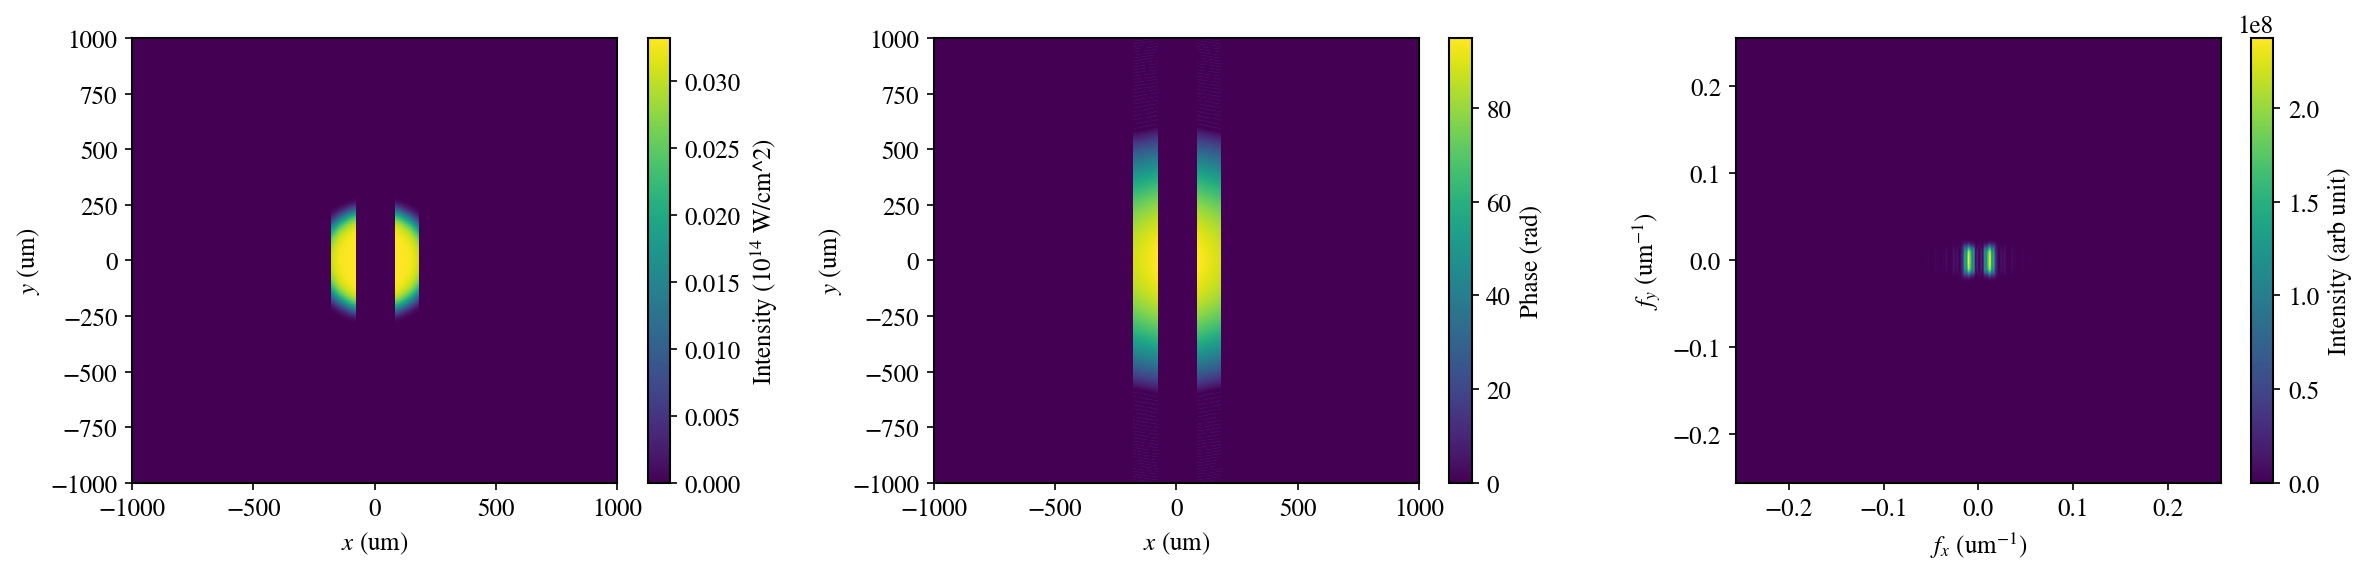

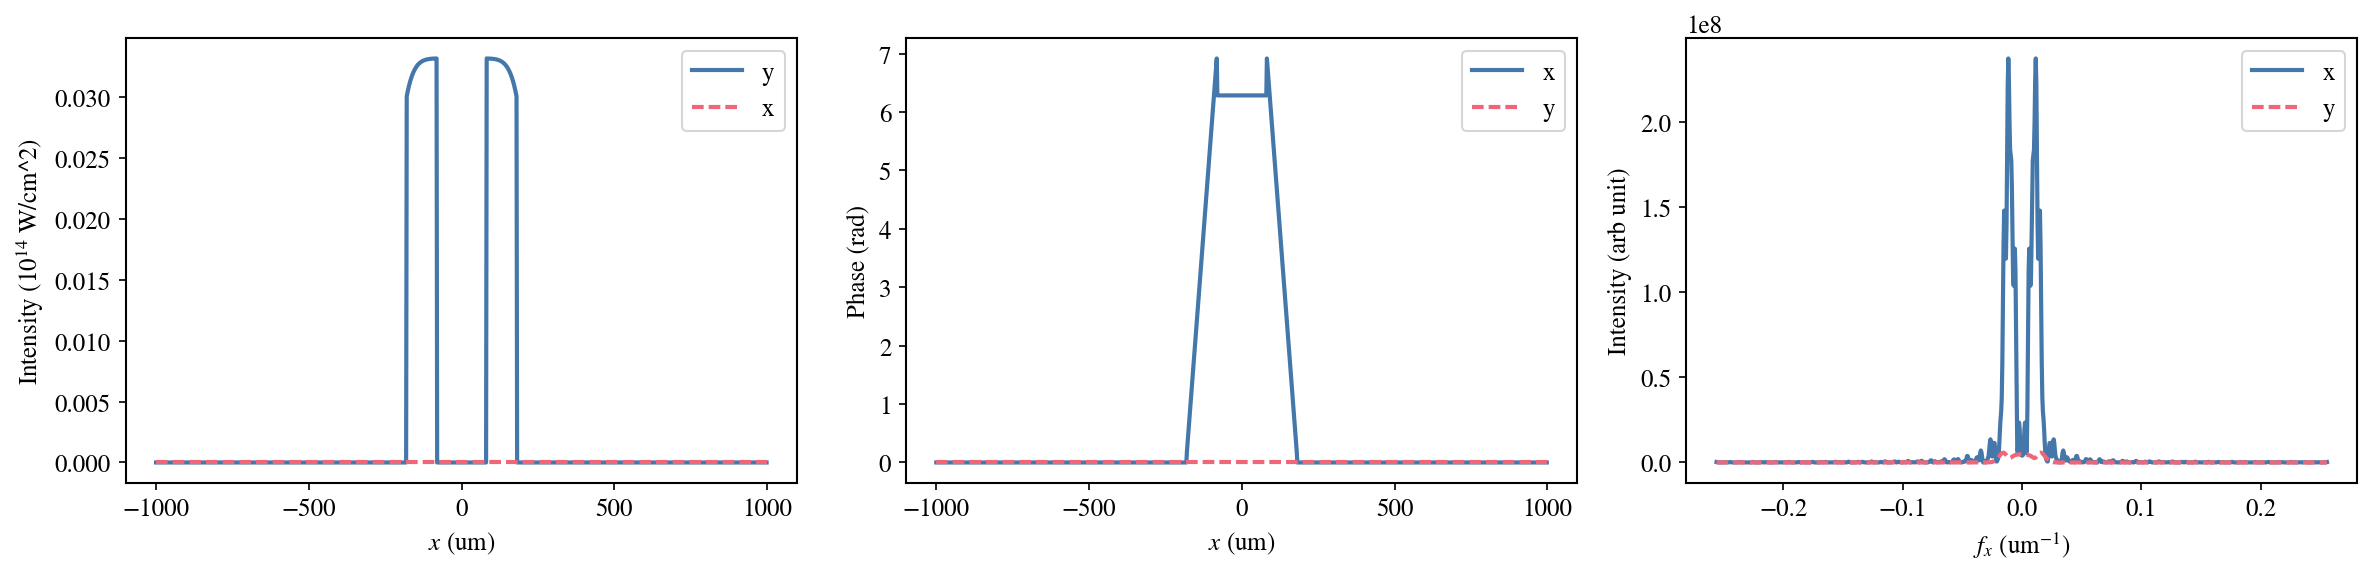

In [6]:
x = abs(beam_in.x)
sel = np.logical_and(x < (r_s+w_s/2), x > (r_s-w_s/2))
beam_in.e[~sel] = 0.0
beam_in.plot_current_field(wrap_order=1)

In [7]:
Nz = 1000
L = 20e3
z0 = f1-L/2
beam_in.propagate(z0, 1.0)
z = np.linspace(0, L, Nz)
beam_in.propagate(z, 1.0)

I = np.zeros((Nz, Nx))
for i in range(Nz):
    I[i, :] = beam_in.intensity_from_field(beam_in.load_field(i+1)[0])
I = beam_in.prep_data(I)

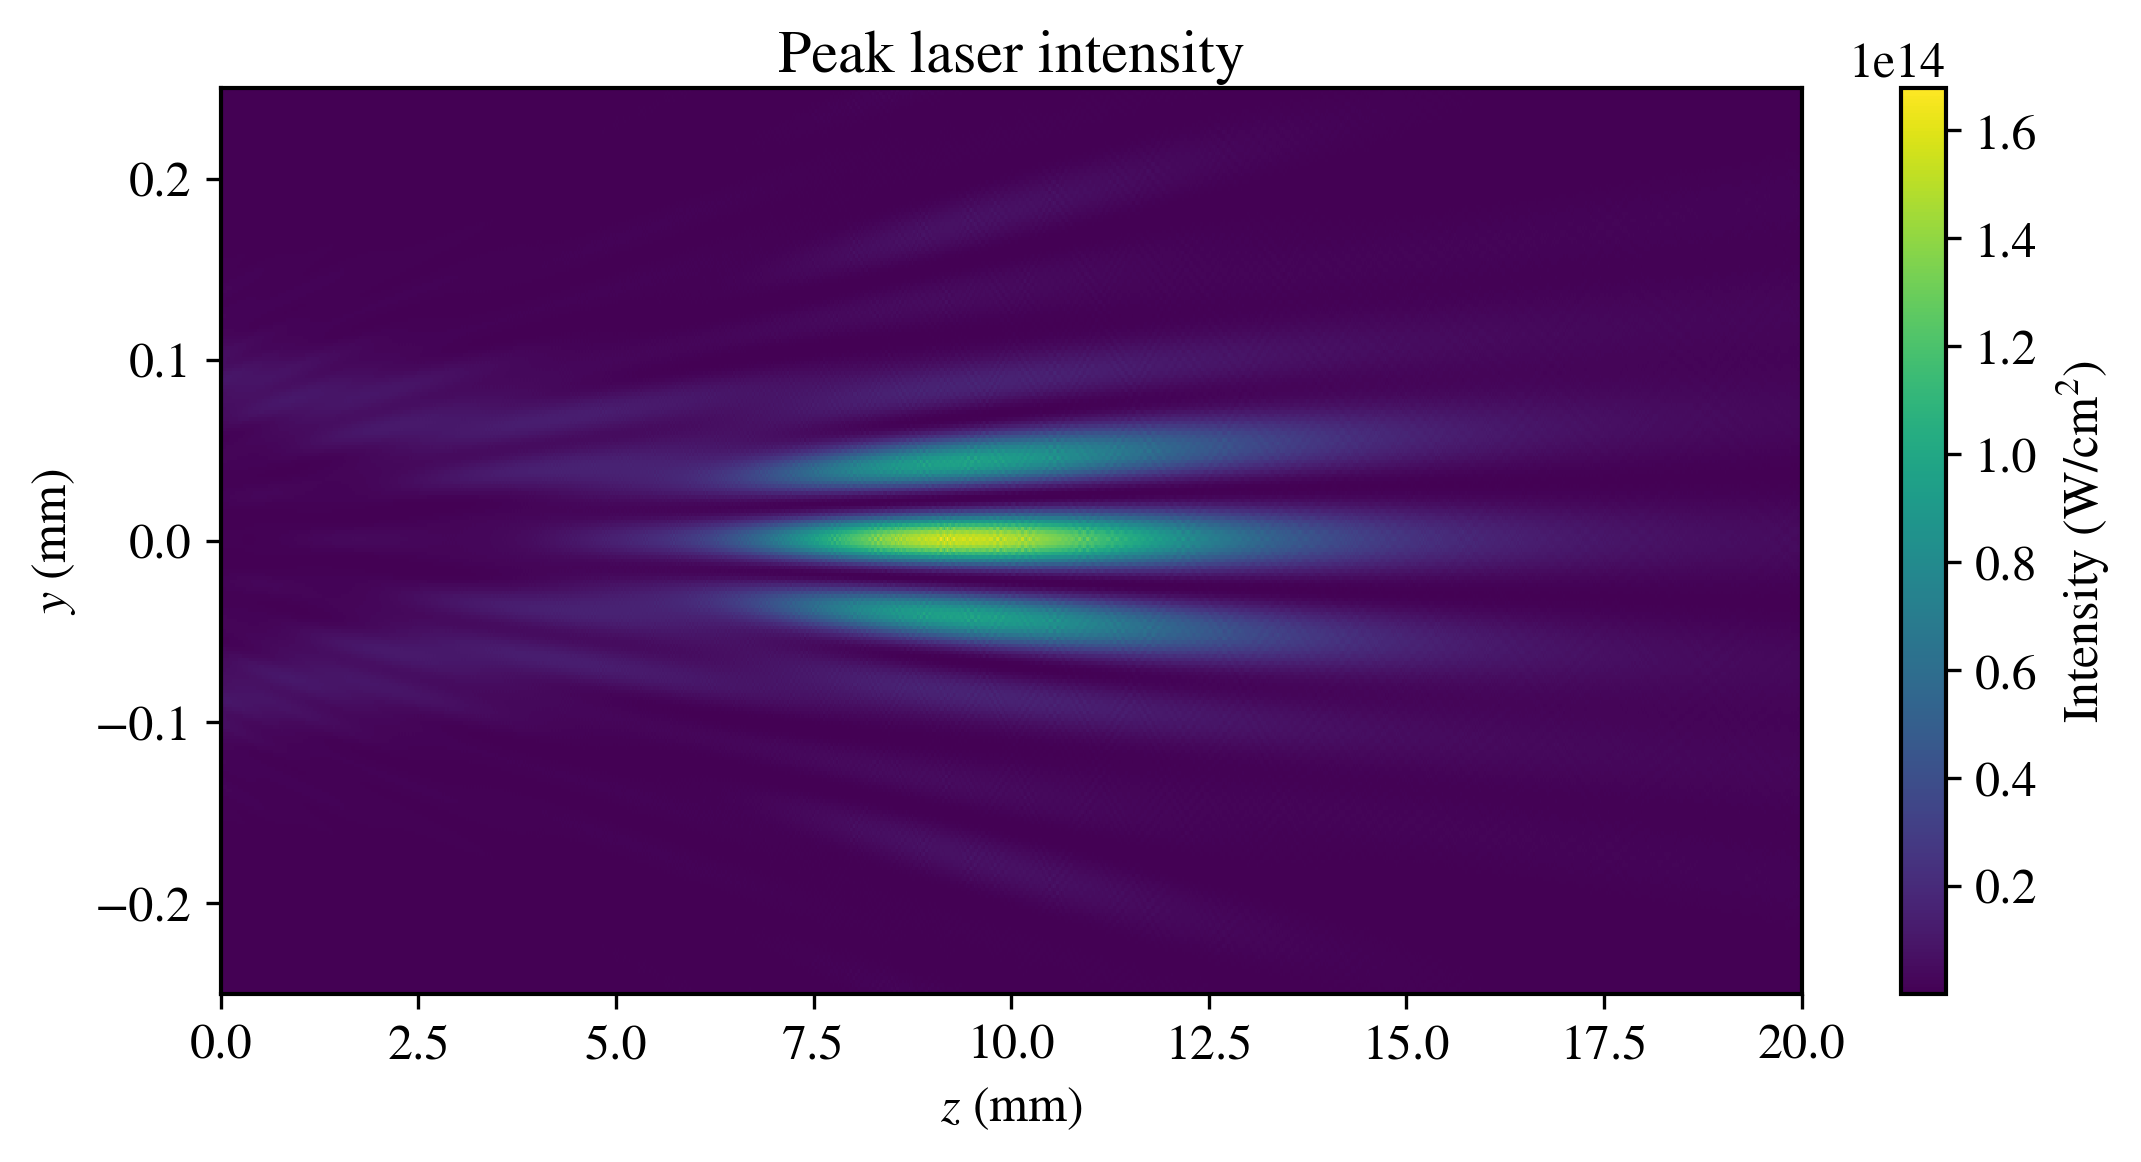

In [8]:
ext = [0, L/1e3, -X/2e3, X/2e3]
plt.figure(figsize=(8.5, 4), dpi=300)
#norm = colors.LogNorm(vmin=1e9, vmax=1e13)
im = plt.imshow(I*1e14, aspect='auto', extent=ext)#, norm=norm)
cb = plt.colorbar()
cb.set_label(r'Intensity ($\mathrm{W/cm^2}$)')
plt.xlabel(r'$z$ (mm)')
plt.ylabel(r'$y$ (mm)')
plt.title('Peak laser intensity')
#plt.xlim(15, 25)
plt.ylim(-0.25, 0.25)
plt.show()

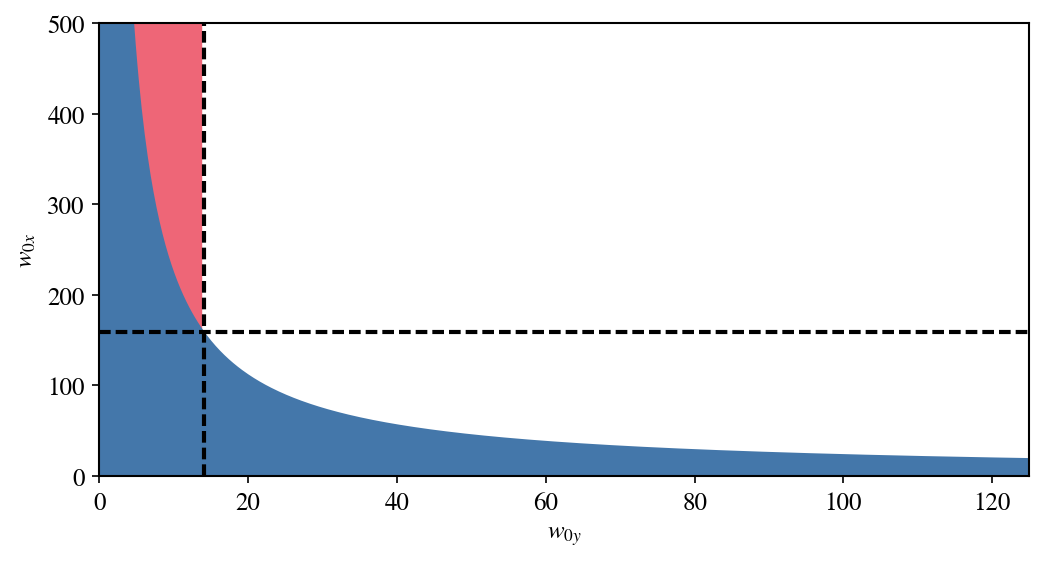

In [9]:
z = 38.67e4
R = 1/2000
w_0y = np.linspace(0.0001, 200, 1000)
plt.figure(figsize=(8, 4), dpi=150)
#w_0x = np.sqrt(lam/np.pi*np.sqrt((np.pi**2*w_0y**4*z**2+lam**2*z**4)/(1/R**2*np.pi**2*w_0y**4-lam**2*z**2)))
#plt.plot(w_0y, w_0x)
w_0x = z*lam*np.sqrt(R)/(np.pi*w_0y)
plt.plot(w_0y, w_0x)
w_0y0 = np.sqrt(4*z*R*lam/np.pi)
plt.plot([w_0y0, w_0y0], [0, 1000], 'k--')
w_0x0 = np.sqrt(z*lam/np.pi/np.sqrt(15))
plt.plot([0, 1000], [w_0x0, w_0x0], 'k--')
plt.fill_between(w_0y, 0, w_0x)
sel = w_0y < w_0y0
plt.fill_between(w_0y[sel], w_0x[sel], 1000)
plt.xlabel(r'$w_{0y}$')
plt.ylabel(r'$w_{0x}$')
plt.xlim(0, 125)
plt.ylim(0, 500)
plt.show()

In [10]:
plt.style.use('notes')
lam = 1
X = 10
Y = 5
x = np.linspace(-X, X, 1000)
y = np.linspace(-Y, Y, 500)
beta = 15*np.pi/180
k = 2*np.pi/lam
kx = k*np.cos(beta)
ky = k*np.sin(beta)
E1 = np.exp(1j*(kx*x[:, None]-ky*y[None, :]))
E2 = np.exp(1j*(kx*x[:, None]+ky*y[None, :]))
E0 = lambda l: np.exp(-l**2/(2*1.5**2))
E1 = E1*E0(x[:, None]*np.sin(beta)+y[None, :]*np.cos(beta))
E2 = E2*E0(-x[:, None]*np.sin(beta)+y[None, :]*np.cos(beta))

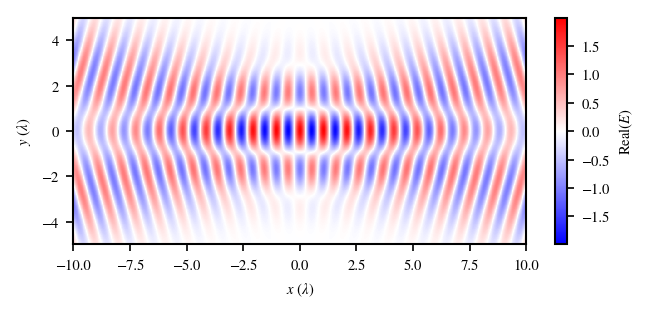

In [11]:
plt.figure(figsize=(5, 2), dpi=150)
plt.imshow(beam_in.prep_data((E1+E2).real), extent=[-X, X, -Y, Y], cmap='bwr')
cb = plt.colorbar()
#cb.set_label(r'$|E|^2$')
cb.set_label(r'Real($E$)')
plt.xlabel(r'$x$ ($\lambda$)')
plt.ylabel(r'$y$ ($\lambda$)')
plt.show()

In [12]:
EE = 2*np.exp(1j*kx*x[:, None])*np.cos(ky*y[None, :])
EE = np.exp(1j*kx*x[:, None])*(E0(x[:, None]*np.sin(beta)+y[None, :]*np.cos(beta))+
                               E0(-x[:, None]*np.sin(beta)+y[None, :]*np.cos(beta)))*np.cos(ky*y[None, :])\
    -np.exp(1j*ky*y[None, :])*E0(-x[:, None]*np.sin(beta)+y[None, :]*np.cos(beta))\
    -np.exp(-1j*ky*y[None, :])*E0(x[:, None]*np.sin(beta)+y[None, :]*np.cos(beta))

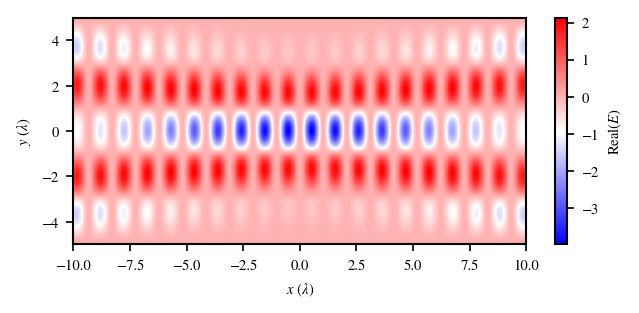

In [13]:
plt.figure(figsize=(5, 2), dpi=150)
plt.imshow(beam_in.prep_data(EE.real), extent=[-X, X, -Y, Y], cmap='bwr')
cb = plt.colorbar()
#cb.set_label(r'$|E|^2$')
cb.set_label(r'Real($E$)')
plt.xlabel(r'$x$ ($\lambda$)')
plt.ylabel(r'$y$ ($\lambda$)')
plt.show()

In [14]:
0.8/(2*200)*1570

3.14